In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import transitFinderFunctions as tff
from astropy.io import fits
from PlanetGenerationExtreme import generate_random_planet_systems, process_system
from transitFinderExtreme import TransitModel, load_model
import importlib
import torch

# Reload the courseworkb module to ensure the latest version is used
importlib.reload(tff)


<module 'transitFinderFunctions' from '/home/omcevoy/AstroCourseworkB/transitFinderFunctions.py'>

In [2]:

def analyze_light_curves(kepler_dataframe, model, device):
    model.eval()
    results = []

    time_array = kepler_dataframe['time'].values
    flux_array = kepler_dataframe['flux'].values

    length_of_input = np.arange(0, 1600, 0.0208333)
    full_flux = np.ones(len(length_of_input), dtype=np.float32)
    time_to_index = {t: i for i, t in enumerate(length_of_input)}

    # Match each flux to the closest time in length_of_input
    for t, flux in zip(time_array, flux_array):
        closest_time = min(length_of_input, key=lambda x: abs(x - t))
        print(f"Closest time: {closest_time}",end='\r')
        if closest_time in time_to_index:
            full_flux[time_to_index[closest_time]] = flux

    tff.plot_light_curve(length_of_input, full_flux)

    # Convert to tensor
    flux_tensor = torch.tensor(full_flux, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        predicted_periods, predicted_num_planets = model(flux_tensor)  # Model output: predicted periods and number of planets
        predicted_periods = [p.cpu().numpy() for p in predicted_periods]
        predicted_num_planets = predicted_num_planets.item()

    print(f"Predicted periods: {predicted_periods}")
    print(f"Predicted number of planets: {predicted_num_planets}")

    results.append((predicted_periods, predicted_num_planets))
    return results

def plot_light_curves(kepler_dataframe, results):
    time_array = kepler_dataframe['time'].values
    flux_array = kepler_dataframe['flux'].values

    predicted_periods, predicted_num_planets = results[0]

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(time_array, flux_array, label='Light curve')
    ax.set_xlabel('Time')
    ax.set_ylabel('Flux')
    ax.set_title(f'Light curve\nPredicted periods: {predicted_periods}, Predicted number of planets: {predicted_num_planets}')
    ax.legend()

    plt.tight_layout()
    plt.show()


/home/omcevoy/AstroCourseworkB/transitFinderExtreme.py:224: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


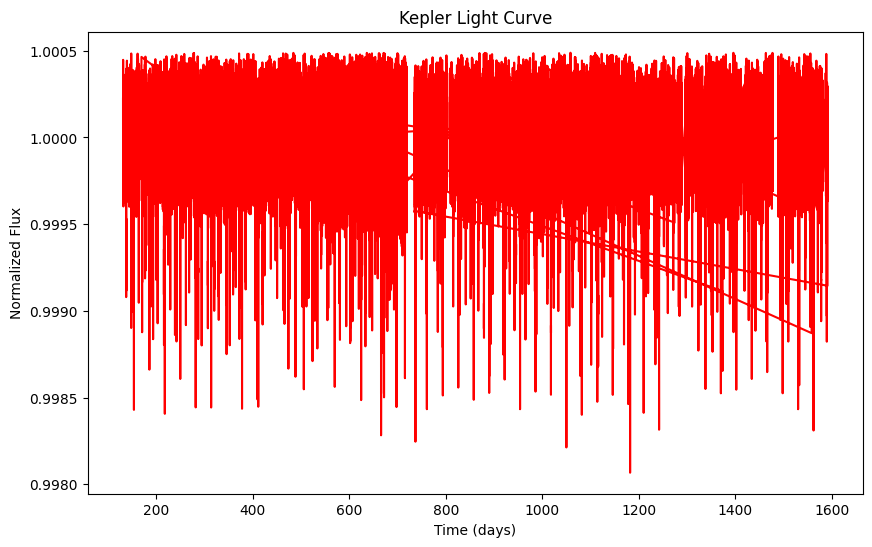

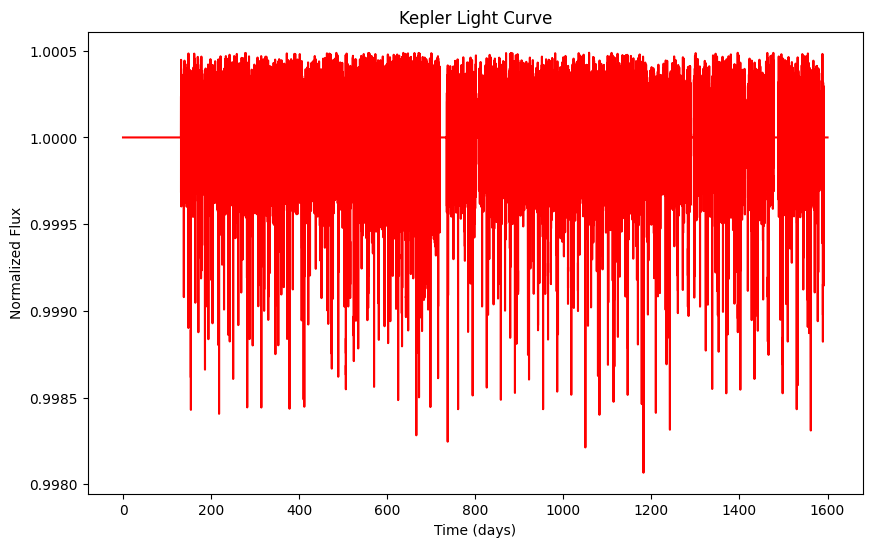

AttributeError: 'list' object has no attribute 'squeeze'

In [3]:

fits_file_path = file_path = 'CourseworkData/Objectlc'
device = "cpu"# torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model("RNN_Model.pth", device)

kepler_dataframe = tff.loadDataFromFitsFiles(fits_file_path,filter_type='medfilt')

tff.plot_light_curve(kepler_dataframe['time'], kepler_dataframe['flux'])
results = analyze_light_curves(kepler_dataframe, model, device)
plot_light_curves(kepler_dataframe,results)
